In [1]:
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy as ap
import pandas as pd
import astropy.cosmology as apc
from astropy.cosmology import Planck18
import bagpipes as pp
import astropy.units as u
import kcorrect
from astropy.io import fits
from mpl_toolkits.mplot3d import axes3d
from astropy.cosmology import FlatLambdaCDM

c = 3e18    #A * Hz
cosmo = FlatLambdaCDM(H0=100, Om0=0.3, Tcmb0=2.725)

In [2]:
df = pd.read_csv("~/Desktop/MT/NYU_VAGC_nearest_petro_00.csv")

df = df.drop(columns='Unnamed: 0')

magmask = (df[[f"maggies_{i}" for i in 'ugriz']] >= 0.).all(axis=1)

ivarmask = (df[[f"ivar_{j}" for j in 'ugriz']] >= 0.).all(axis=1)

zmaskh = df['redshift'] > 1e-3

zmaskl = df['redshift'] < 2.

mask_total = magmask & zmaskh & ivarmask & zmaskl

In [3]:
df1 = df[mask_total]

df1

,redshift,k_u,k_g,k_r,k_i,k_z,M_u,M_g,M_r,M_i,...,ivar_r,ivar_i,ivar_z,coeffs_u,coeffs_g,coeffs_r,coeffs_i,coeffs_z,RA,DEC
3,0.088372,0.268087,0.240492,0.099534,0.042457,0.038538,-18.130915,-19.653049,-20.392693,-20.725468,...,8.496057e+16,3.926725e+16,6.443611e+15,3.140549e-06,9.204366e-10,5.222372e-07,4.209332e-05,8.206721e-11,337.450310,1.266134
4,0.163800,0.541633,0.551045,0.216683,0.129382,0.093125,-18.654232,-20.847889,-21.607784,-21.919483,...,3.069960e+16,5.100199e+15,1.585379e+15,5.876272e-06,1.472155e-21,1.868628e-08,3.201247e-05,1.814333e-07,338.114079,1.271937
5,0.163800,0.625966,0.519851,0.174484,0.060106,0.042541,-18.499475,-20.402464,-21.348362,-21.763556,...,1.966820e+16,3.494913e+15,2.081640e+15,9.594096e-33,1.681558e-44,5.886154e-07,2.434476e-05,1.076729e-29,338.115522,1.270146
8,0.143369,0.417254,0.346987,0.150486,-0.031666,0.035319,-19.000532,-20.277908,-20.937681,-21.207977,...,6.806910e+15,8.849206e+15,7.335961e+15,2.311139e-06,5.352486e-10,1.561921e-06,1.444467e-05,5.777484e-11,341.101481,1.266255
9,0.143369,0.292242,0.368434,0.153013,0.095682,0.052898,-19.205385,-20.752714,-21.390358,-21.739124,...,4.553791e+16,2.021259e+16,5.914580e+15,5.313505e-06,1.984782e-18,1.049956e-09,3.237387e-05,6.631446e-07,341.098882,1.266247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506739,0.347070,2.175346,1.424035,0.495711,0.266503,0.173644,-21.371435,-21.535664,-22.400696,-22.729414,...,6.676902e+17,2.714567e+17,3.852778e+16,4.952928e-07,3.060275e-27,1.764312e-08,1.436807e-05,1.685200e-14,162.618774,9.915339
2506741,0.037024,0.032126,-0.003826,0.046103,-0.024840,-0.004967,-16.979965,-17.731892,-18.109447,-18.191107,...,1.294251e+17,8.917608e+16,1.639320e+16,2.850467e-06,8.353498e-09,1.874611e-06,7.473393e-06,7.548712e-07,162.644268,9.942940
2506743,0.031433,0.017574,-0.030080,0.033331,-0.048114,-0.050976,-18.167137,-18.757174,-18.946445,-18.897882,...,1.531959e+16,9.174796e+15,1.671111e+15,9.656645e-17,4.455161e-08,6.333021e-06,2.619261e-09,3.855989e-06,162.709169,10.059970
2506745,1.569001,-0.666364,-0.358855,-0.393851,-0.546141,-0.682044,-24.345951,-24.696672,-24.771935,-24.724669,...,1.038716e+18,3.855867e+17,1.447415e+17,1.763988e-15,2.144042e-09,2.508398e-08,6.128497e-13,2.057390e-07,162.018838,9.978860


# DATA LOADER

In [4]:
rahmask = df['RA'] < 163

ralmask = df['RA'] > 161.8

dechmask = df['DEC'] < 10.5

declmask = df['DEC'] > 9.5

posmask = rahmask & ralmask & dechmask & declmask

dfpos = df1[posmask]

/tmp/ipykernel_14856/917270793.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfpos = df1[posmask]


In [ ]:
# data loading for objects
test = df1[:] # iloc = index location ; syntax are [row, columns] => deprecated

x = len(test)

_ktest = [f'k_{i}' for i in 'ugriz']
k_test = test[_ktest]

_absmag_test = [f'M_{i}' for i in 'ugriz']
absmag_test = test[_absmag_test]

redshift = test['redshift']

_maggies = [f'maggies_{i}' for i in 'ugriz']
maggies = test[_maggies]

_ivar = [f'ivar_{i}' for i in 'ugriz']
ivar = test[_ivar]

sm = test['Stellar_Mass']

_coeffs = [f'coeffs_{i}' for i in 'ugriz']
coeffs1 = test[_coeffs]

'_bands = [f\'modelmag_{i}\' for i in \'ugriz\']\nm_k = test[_bands]            # appmags with k inside    \n\n_banderrs = [f\'modelmagErr_{i}\' for i in \'ugriz\']\nm_k_errs = test[_banderrs]    # appmag errors\n\nphot_reds = test[\'z\']        # photometric redshifts\nphot_reds_err = test[\'z_err\']# redshift errors\n\n_ivars = [f\'modelFluxivar_{i}\' for i in \'ugriz\']\nivar_cat = test[_ivars]       # ivars for bands\n\n_absmags = [f\'absMag{i}\' for i in \'UGRIZ\']\nabsmagtest = test[_absmags]\nabsmagtest = absmagtest.to_numpy(dtype=float)\n\n_fluxess = [f\'modelFlux_{i}\' for i in \'ugriz\']\nfluxtest = test[_fluxess]    # flux_nu in nanomaggies\n\n_kcorrbands = [f\'kcorr{i}\' for i in \'UGRIZ\']\nk_corr_cat = test[_kcorrbands] # k-correct from catalog\nk_corr_cat = k_corr_cat.to_numpy(dtype=float)\n\nsm = test[\'lgm_tot_p50\']    # stellar mass from SDSS\nsmh = test[\'lgm_tot_p84\']   # upper limit\nsml = test[\'lgm_tot_p16\']   # lower limit\nsm = sm.to_numpy(dtype=float)\nsmh 

# Kcorrect Test

In [ ]:
responses = ['sdss_u0', 'sdss_g0','sdss_r0','sdss_i0','sdss_z0']
kz = kcorrect.kcorrect.Kcorrect(responses=responses,cosmo=cosmo)

coeffs = kz.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)


In [49]:
# maggies to appmag, DM calc
appmag = -2.5*np.log10(maggies)

d = cosmo.luminosity_distance(redshift)/u.Mpc
DM = 25 + 5*np.log10(d)
DM = np.broadcast_to(DM.reshape(-1,1), (x,5))

In [11]:
(coeffs/coeffs1).median()

coeffs_u    0.424039
coeffs_g    0.238955
coeffs_r    0.799874
coeffs_i    1.014744
coeffs_z    0.000000
dtype: float64

In [12]:
# getting k corrections
K = kz.kcorrect(redshift=redshift, coeffs=coeffs)       # we have k values to clean out redshift effects from the appmag

M = kz.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs) # works fine this time around: M = m -DM -K

derived = kz.derived(redshift=redshift, coeffs=coeffs)
smk = derived['mremain']

In [50]:
M_calc = appmag - DM - K

In [26]:
M_r = M[:,2]
absmag_test_r = absmag_test['M_r']
K_r = K[:,2]
K_r_cat = k_test.iloc[:,2]

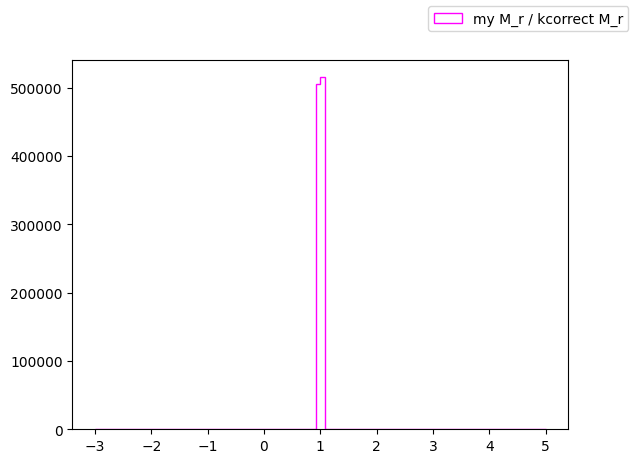

In [56]:
fig, ax = plt.subplots()
plt.hist(M_calc.iloc[:,2]/M_r, bins=100, range=[-3,5], histtype="step",label="my M_r / kcorrect M_r",color="fuchsia")
fig.legend()

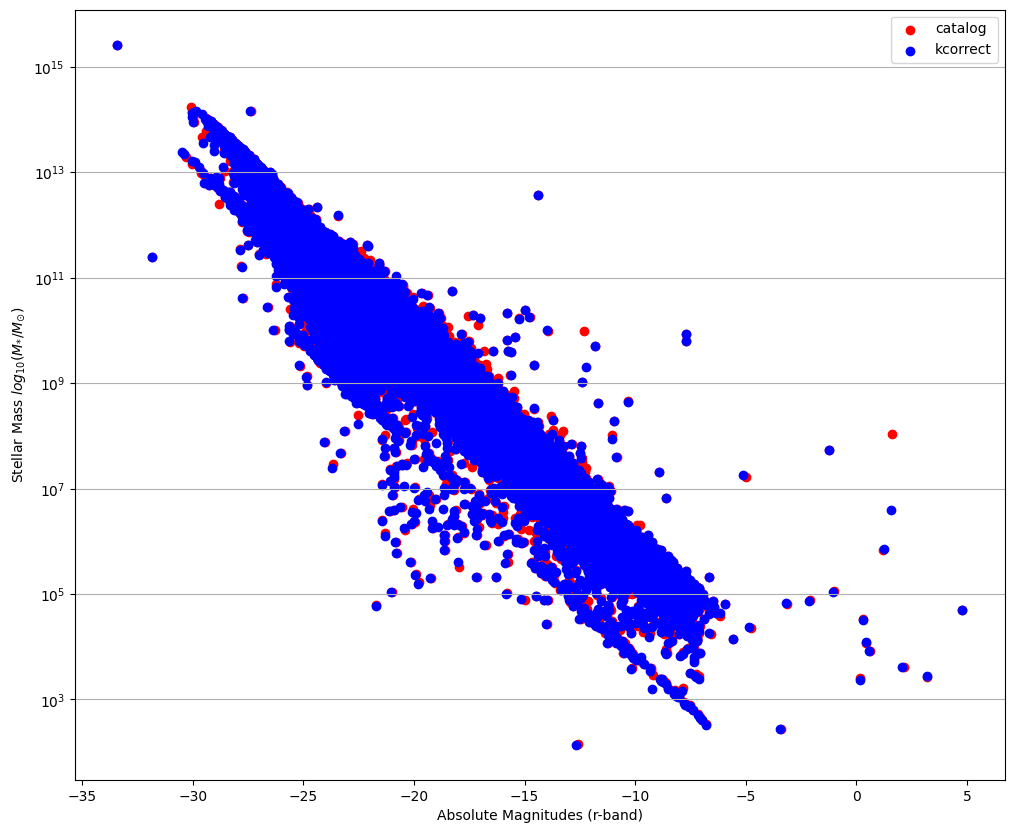

In [20]:
fig, ax = plt.subplots()
plt.scatter(absmag_test_r, sm,  marker="o", c='r', label='catalog')
plt.scatter(M_r, smk, marker='o', c='b', label='kcorrect')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Absolute Magnitudes (r-band)')

ax.grid(axis='y',which='both')
fig.set_size_inches(12,10)
plt.show()

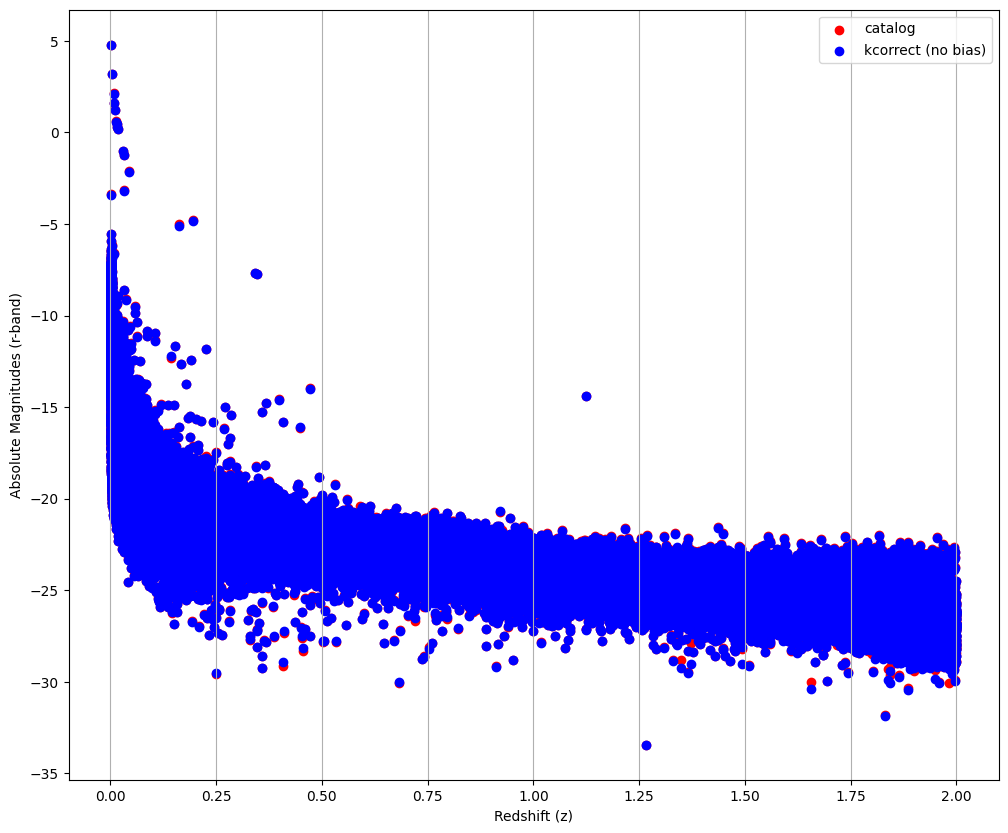

In [21]:
fig, ax = plt.subplots()

plt.scatter(redshift, absmag_test_r, marker="o", c='r', label='catalog')
plt.scatter(redshift, M_r, marker='o', c='b', label='kcorrect (no bias)')


ax.set_yscale('linear')
ax.set_xscale('linear')

ax.legend()
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Absolute Magnitudes (r-band)')

ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()

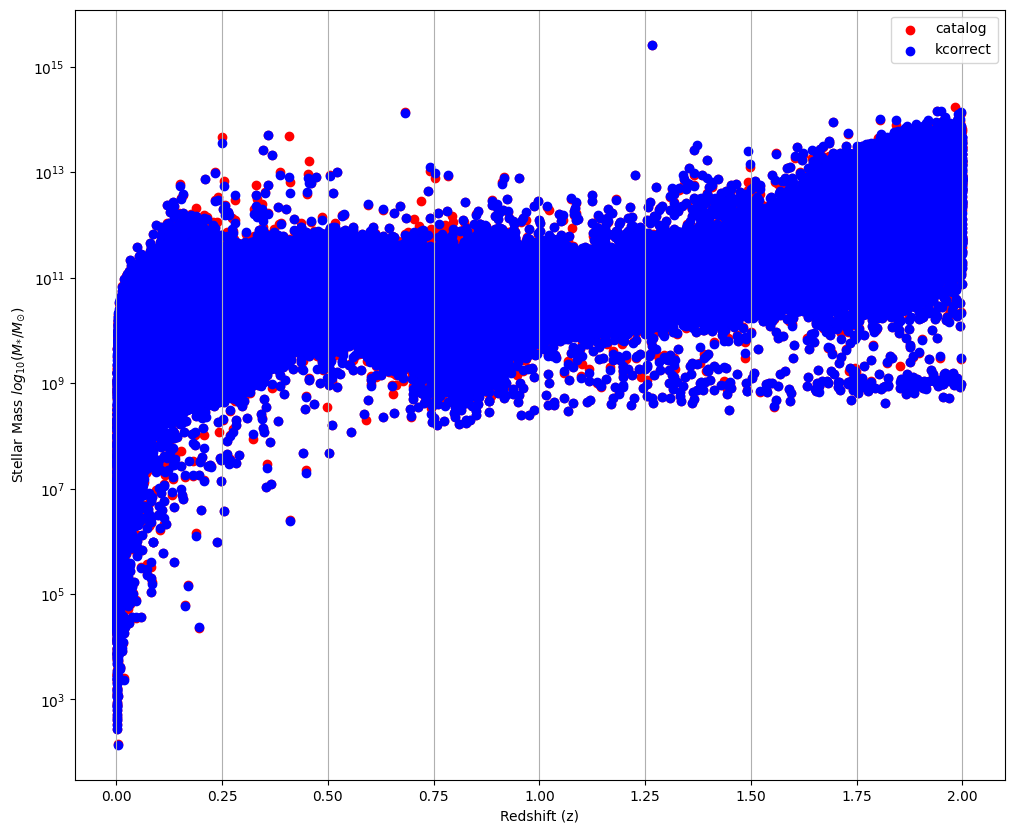

In [22]:
fig, ax = plt.subplots()
plt.scatter(redshift, sm, marker="o", c='r', label='catalog')
plt.scatter(redshift, smk, marker='o', c='b', label='kcorrect')

ax.set_yscale('log')
ax.set_xscale('linear')

ax.legend()
ax.set_ylabel(r'Stellar Mass $log_{10}(M_{*}/M_{\odot})$')
ax.set_xlabel('Redshift (z)')
ax.grid(axis='x')

fig.set_size_inches(12,10)
plt.show()

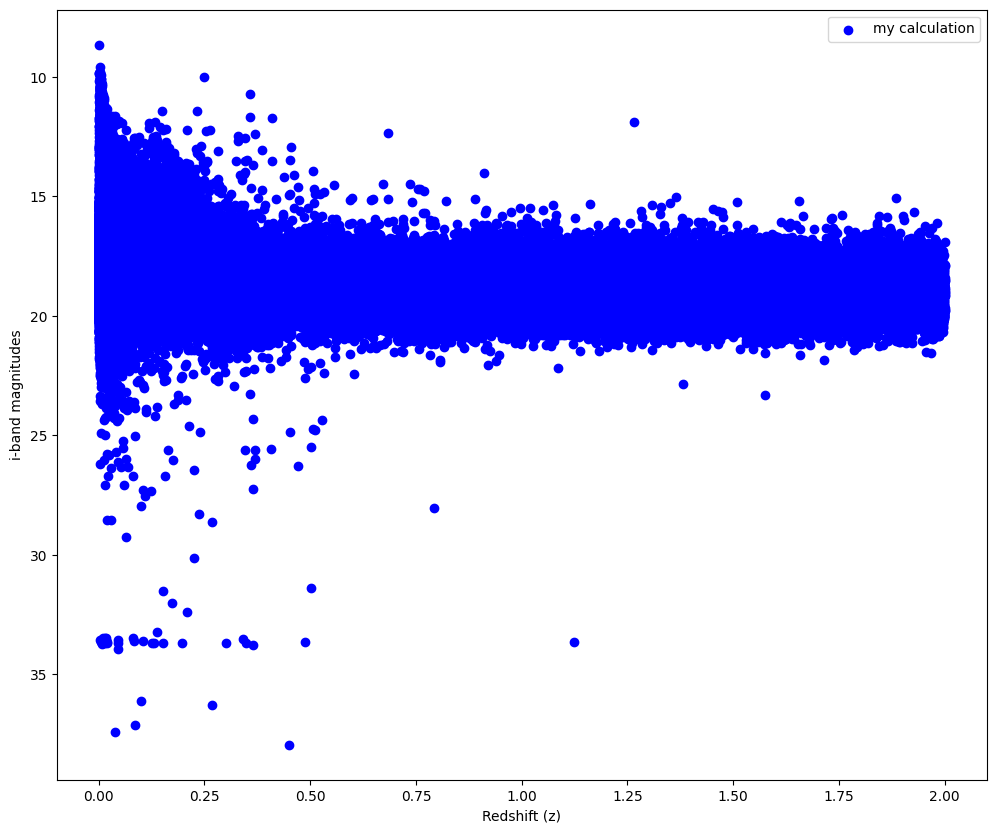

In [47]:
fig, ax = plt.subplots()
plt.scatter(redshift, appmag.iloc[:,3], marker="o", c='b',label='my calculation')

ax.legend()
ax.set_ylabel('i-band magnitudes')
ax.set_xlabel('Redshift (z)')
ax.yaxis.set_inverted(True)
fig.set_size_inches(12,10)
plt.show()